# Example: Forecasting with an ARX model

This notebook demonstrates how to use an autoregressive model with exogenous variables to forecast day-ahead electricity prices.

## 1. Load Data

First, let's load the processed electricity and forecast data.

In [1]:
# preamble
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from typing import Tuple, Optional

from electricity_pricing.models import ARXModel
from electricity_pricing.data.loading import load_and_merge_datasets
from electricity_pricing.utils import get_expected_periods, create_timestamps, validate_timestamps
import electricity_pricing.eval_metrics as metrics

In [2]:
print("\nLoading data...")

base_path = "../data/processed"
df = load_and_merge_datasets(
    electricity_path=f"{base_path}/electricity_data.csv",
    forecast_path=f"{base_path}/forecast_data.csv",
    date_range=(dt.date(2024, 1, 1), dt.date(2024, 12, 31)),
    validate=True,
    verbose=False
)

# create timestamps and set them as indices
df['SETTLEMENT_DATE'] = pd.to_datetime(df['SETTLEMENT_DATE'])
df['DATETIME'] = create_timestamps(df, date_column='SETTLEMENT_DATE', period_column='SETTLEMENT_PERIOD')
validate_timestamps(df, datetime_column='DATETIME', date_column='SETTLEMENT_DATE', period_column='SETTLEMENT_PERIOD')
df = df.sort_values(by='DATETIME', ascending=True).reset_index(drop=True)
df.set_index('DATETIME', inplace=True)

assert not df.isna().values.any(), "DataFrame has NaN values."

print(f"Loaded {len(df)} records from {df.index[0].date()} to {df.index[-1].date()}")


Loading data...
Loaded 17472 records from 2024-01-01 to 2024-12-30


## 2. Construct Features

Features for the ARX model:

**Autoregressive features:**
- Lagged prices from previous settlement periods (1, 2, 3 periods ago)
- Lagged prices from same period on previous days (1 day, 7 days ago)

**Exogenous variables:**
- Suppressed demand (demand forecast - embedded generation)
- Wind generation forecast
- Gas prices (lagged 2 days)

**Temporal features:**
- Holiday indicator
- Weekend indicator

In [3]:
print("\nCreating features...")

from electricity_pricing.utils import timeshift, is_holiday, is_weekend

# Autoregressive features
df[f'price_lag_24h'] = timeshift(df['marketIndexPrice'], pd.Timedelta(days=-1))
df[f'price_lag_7d'] = timeshift(df['marketIndexPrice'], pd.Timedelta(days=-7))

# Exogenous features
df['suppressed_demand'] = df['DEMAND_FORECAST'] - df['EMBEDDED_WIND_FORECAST'] - df['EMBEDDED_SOLAR_FORECAST']
df['wind_gen'] = df['WIND_FORECAST']
df['gas_price'] = timeshift(df['naturalGasPrice'], pd.Timedelta(days=-2))

# Time-related features
# Day of week, weekends, holidays
df['dayofweek'] = df.index.dayofweek
df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
df['is_holiday'] = is_holiday(df, 'SETTLEMENT_DATE', country='GB')
df['is_weekend'] = is_weekend(df, 'SETTLEMENT_DATE')

# Settlement period
# # use 4*pi since there are typically two peak periods per day
df['period_sin'] = np.sin(4 * np.pi * (df['SETTLEMENT_PERIOD'] - 1) / 48)
df['period_cos'] = np.cos(4 * np.pi * (df['SETTLEMENT_PERIOD'] - 1) / 48)

# Month
df['month'] = df.index.month
df['month_sin'] = np.sin(2 * np.pi * (df['month'] - 1) / 12)
df['month_cos'] = np.cos(2 * np.pi * (df['month'] - 1) / 12)

# Fill forward missing values (up to 3 periods)
df = df.ffill(limit=3).dropna()

# # Define target and features
endog = df['marketIndexPrice'].copy()
exog = df[[
    'price_lag_24h', 'price_lag_7d',
    'suppressed_demand', 'wind_gen', 'gas_price', 
    'is_holiday', 'is_weekend',
    'dayofweek_sin', 'dayofweek_cos',
    'period_sin', 'period_cos',
    'month_sin', 'month_cos',
]].copy()

print(f"Features: {list(exog.columns)}")
print(f"Final dataset: {len(endog)} records")


Creating features...
Features: ['price_lag_24h', 'price_lag_7d', 'suppressed_demand', 'wind_gen', 'gas_price', 'is_holiday', 'is_weekend', 'dayofweek_sin', 'dayofweek_cos', 'period_sin', 'period_cos', 'month_sin', 'month_cos']
Final dataset: 17001 records


## 3. Forecasting

Let's use a rolling window (walk-forward) forecasting and validation method:
- For each day, train on the last N days
- Generate a day-ahead forecast for the next day
- Slide the window forward and repeat

In [4]:
# Helper functions
def get_periods_remaining(timestamp: pd.Timestamp, freq: str = "30min") -> int:
    """
    Return the number of settlement periods remaining in the day after `timestamp`.
    """
    total_periods = get_expected_periods(timestamp)
    midnight = timestamp.normalize()
    time_since_midnight = timestamp - midnight
    current_period = int(time_since_midnight / pd.Timedelta(freq)) + 1
    return total_periods - current_period + 1


def get_window(
    df: pd.DataFrame | pd.Series, 
    start: pd.Timestamp, 
    end: pd.Timestamp,
    which: str = "left") -> pd.DataFrame | pd.Series:
    """
    Extract window ending at specified dt.

    Args:
        df: DataFrame or Series with datetime index
        start: Start datetime for training window
        end: End datetime for training window
        which: Whether to include 
            the start datetime: "left" (default)
            the end datetime  "right"
            or "both".
    """
    if which == "left":
        return df[(df.index >= start) & (df.index < end)].copy()
    elif which == "right":
        return df[(df.index > start) & (df.index <= end)].copy()
    elif which == "both":
        return df[(df.index >= start) & (df.index <= end)].copy()
    else:
        raise ArgumentError(f"Unexpected argument. Got `which` = {which}.")


def lookahead(df: pd.DataFrame, timestamp: pd.Timestamp, n: int) -> pd.DataFrame:
    """
    Extract first n rows after `timestamp`.

    Args:
        df: DataFrame with datetime index
        timestamp: Start datetime
        n: Number of steps ahead to look
    """
    future = df[df.index >= timestamp].head(n)

    if len(future) < n:
        raise ValueError(f"Not enough data: need {n} steps, got {len(future)}")

    return future

In [5]:
# Forecast function
def rolling_day_ahead_forecast(
    model: ARXModel,
    endog: pd.Series,
    exog: Optional[pd.DataFrame],
    days: int,
    window_size: int = 30,
    issue_time: dt.time = dt.time(9, 0)) -> Tuple[pd.Series, pd.Series]:
    """
    Perform rolling day-ahead forecast.

    For each day in the forecast range, this function:
    1. Fits the model on a rolling window of historical data
    2. Generates a forecast for the remainder of today + all of tomorrow
    3. Extracts and stores tomorrow's forecast
    4. Advances to the next day

    Args:
        model: ForecastModel instance (will be refitted each day)
        endog: Endogenous variable (prices) as a `pandas.Series` with datetime index
        exog: Optional
            If provided, should be a `pandas.DataFrame` of exogenous variables with datetime index
            Default: None
        days: Number of days to forecast
        window_size: Number of past days to use for training
        issue_time: Time of day to issue forecast (default: 09:00)

    Returns:
        forecasts: `pandas.Series` of forecasted prices with datetime index
    """
    if exog is not None:
        assert (endog.index == exog.index).all()

    timestamps = endog.index
    start_date = timestamps.min().date()
    end_date = timestamps.max().date()
    issue_date_1 = start_date + pd.Timedelta(days=window_size)  # date on which first forecast is made
    issue_dates = pd.date_range(issue_date_1, issue_date_1 + pd.Timedelta(days=days), freq='D', tz='Europe/London')

    forecasts_list = []
    indices_list = []

    for date in issue_dates:
        # time at which forecast is made
        issue_ts = pd.Timestamp(
            year=date.year, month=date.month, day=date.day, 
            hour=issue_time.hour, minute=issue_time.minute, tz='Europe/London')

        # collect required history to start forecasting
        start = issue_ts - pd.Timedelta(days=window_size)
        endog_train = get_window(endog, start, issue_ts, which="left")
        exog_train = get_window(exog, start, issue_ts, which="left") if exog is not None else None

        # fit model on training data
        model.fit(endog_train, exog=exog_train)

        # Calculate forecast horizon
        n_periods_issue = get_periods_remaining(issue_ts)
        target_date = issue_ts + pd.Timedelta(days=1)
        n_periods_target = get_expected_periods(target_date)
        horizon = n_periods_issue + n_periods_target

        # Get future exogenous variables
        exog_future = lookahead(exog, issue_ts, horizon) if exog is not None else None

        # Make intraday + day-ahead forecast
        forecast = model.forecast(steps=horizon, exog=exog_future)

        # Extract target (day-ahead) forecast
        day_ahead_forecast = forecast[-n_periods_target:]

        # Create timestamps for forecast
        stamps = pd.date_range(
            target_date.normalize(), (target_date + pd.Timedelta(days=1)).normalize(), 
            freq='30min', tz='Europe/London', inclusive="left")

        forecasts_list.append(day_ahead_forecast)
        indices_list.append(stamps)

    # Combine all forecasts
    all_forecasts = np.concatenate(forecasts_list)
    all_indices = pd.DatetimeIndex(np.concatenate(indices_list))

    forecasts_series = pd.Series(all_forecasts, index=all_indices, name='forecast')

    return forecasts_series

In [6]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import HistGradientBoostingRegressor

print("\nSetting up model...")

days = 14  # number of days to forecast
window_size = 90  # size of training window

# Create model
model = ARXModel(lags=[1, 2], regressor=LinearRegression(fit_intercept=True))
# model = ARXModel(lags=[1, 2, 3, 4], regressor=HistGradientBoostingRegressor())

print(f"Forecasting {days} days")
print(f"Training window: {window_size} days")
print(f"Model: ARX with lags {model.lags}")

print("\nRunning forecast...")

result = rolling_day_ahead_forecast(
    model=model,
    endog=endog.diff().dropna(),  # differenced for stationarity
    exog=exog.diff().dropna(),  # differenced for stationarity
    days=days,
    window_size=window_size,
    issue_time=dt.time(9, 0)
)

# convert differenced result to forecast
forecasts = result.cumsum() + endog[result.index[0] - pd.Timedelta('30min')]

print(f"Forecast complete: {len(forecasts)} periods forecasted")


Setting up model...
Forecasting 14 days
Training window: 90 days
Model: ARX with lags [1, 2]

Running forecast...
Forecast complete: 720 periods forecasted


## 4. Evaluate Forecast Accuracy

In [7]:
# Helper function
def evaluate_forecast(actuals: pd.Series, forecasts: pd.Series) -> dict:
    return {
        'RMSE (£/MWh)': metrics.rmse(actuals, forecasts),
        'Relative RMSE': metrics.relative_rmse(actuals, forecasts),
        'MAE (£/MWh)': metrics.mae(actuals, forecasts),
        'MAPE (%)': metrics.mape(actuals, forecasts),
        'R²': metrics.r2_score(actuals, forecasts)
    }

In [8]:
print("\nEvaluating forecast performance...")
actuals = get_window(endog, forecasts.index.min(), forecasts.index.max(), which="both")
results = evaluate_forecast(actuals, forecasts)

print("\n   Metrics:")
print("-" * 40)
for metric, value in results.items():
    print(f"{metric:20s}: {value:8.2f}")
print("-" * 40)


Evaluating forecast performance...

   Metrics:
----------------------------------------
RMSE (£/MWh)        :    23.67
Relative RMSE       :    11.84
MAE (£/MWh)         :    19.73
MAPE (%)            :   260.18
R²                  :     0.45
----------------------------------------


## 5. Plot Results

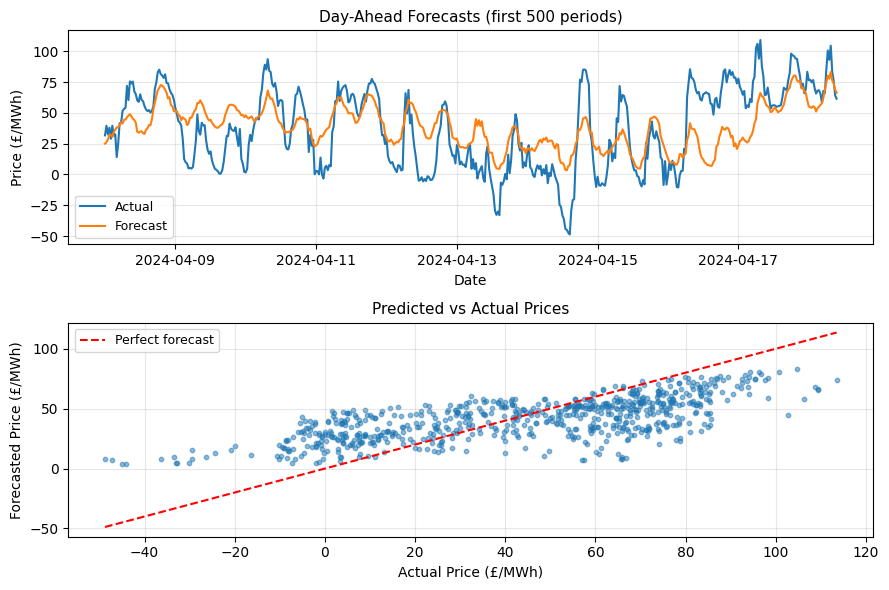

In [9]:
# number of samples to plot
n_samples = 500

fig, axes = plt.subplots(2, 1, figsize=(9, 6))

# Plot 1: Time series (first n_samples)
plot_samples = min(n_samples, len(actuals))
axes[0].plot(actuals.iloc[:plot_samples], label='Actual')
axes[0].plot(forecasts.iloc[:plot_samples], label='Forecast')
axes[0].set_xlabel('Date', fontsize=10)
axes[0].set_ylabel('Price (£/MWh)', fontsize=10)
axes[0].set_title(f'Day-Ahead Forecasts (first {plot_samples} periods)', fontsize=11)
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)

# Plot 2: Scatter plot
axes[1].scatter(actuals, forecasts, alpha=0.5, s=10)
axes[1].plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'r--', label='Perfect forecast')
axes[1].set_xlabel('Actual Price (£/MWh)', fontsize=10)
axes[1].set_ylabel('Forecasted Price (£/MWh)', fontsize=10)
axes[1].set_title('Predicted vs Actual Prices', fontsize=11)
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()

plt.show()

## 6. Study Residuals

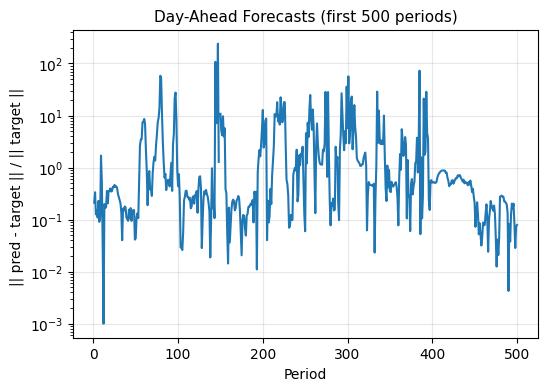

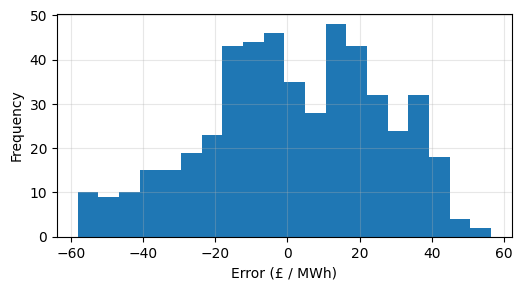

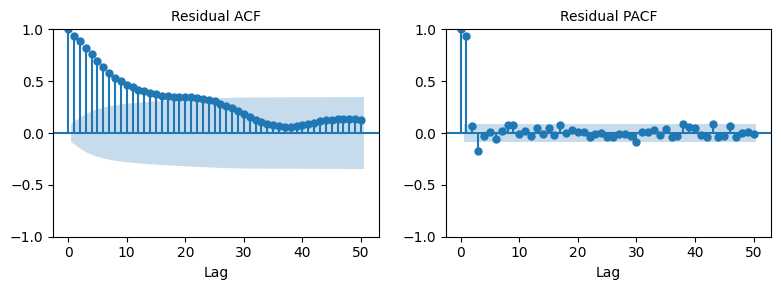

In [10]:
# number of samples to plot
n_samples = 500
residuals = forecasts.iloc[:plot_samples] - actuals.iloc[:plot_samples]
errors = np.sqrt((residuals**2 / actuals.iloc[:plot_samples]**2))

fig, ax = plt.subplots(figsize=(6, 4))
plot_samples = min(n_samples, len(actuals))
ax.plot(np.arange(1, len(errors)+1), errors)
ax.set_xlabel('Period', fontsize=10)
ax.set_ylabel('|| pred - target || / || target || ', fontsize=10)
ax.set_title(f'Day-Ahead Forecasts (first {plot_samples} periods)', fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
plt.show()

# histogram of errors
fig, ax = plt.subplots(figsize=(16/3, 9/3), layout='tight')
ax.hist(residuals, bins=20)
ax.set_xlabel('Error (£ / MWh)', fontsize=10)
ax.set_ylabel('Frequency', fontsize=10)
ax.grid(True, alpha=0.3)
plt.show()

# residual auto-correlation and partial auto-correlations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16/2, 9/3), layout='tight')
plot_acf(residuals, lags=50, ax=ax1)
ax1.set_title('Residual ACF', fontsize=10)
ax1.set_xlabel('Lag', fontsize=10)
plot_pacf(residuals, lags=50, ax=ax2)
ax2.set_title('Residual PACF', fontsize=10)
ax2.set_xlabel('Lag', fontsize=10)
plt.show()